# Introduction to Pytorch Lightning to Fight Overfitting ⚡


In this lab exercise we will use pytorch-lightning, which is a library that works on top of Pytorch and helps in developing more organized code as well focusing more on research and less in engineering. 


  - Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/latest/)


  Also, we will explore some techniques to fight agains overfitting as using dropout and l2-regularization.
 

### Setup  
Lightning is easy to install. Simply ```pip install pytorch-lightning```

In [ ]:
! pip install pytorch-lightning --quiet

In [ ]:
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
## importing pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from pytorch_lightning.callbacks import ModelCheckpoint 

# other packages usefull for this tutorial
import gzip
import pandas as pd
import requests
from sklearn.model_selection  import train_test_split
import numpy as np
import requests



## set the seed
pl.seed_everything(42)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

gpu = 1 if torch.cuda.is_available() else 0
print(f'Using {gpu} GPUS')


# We will use the Higgs Dataset. 




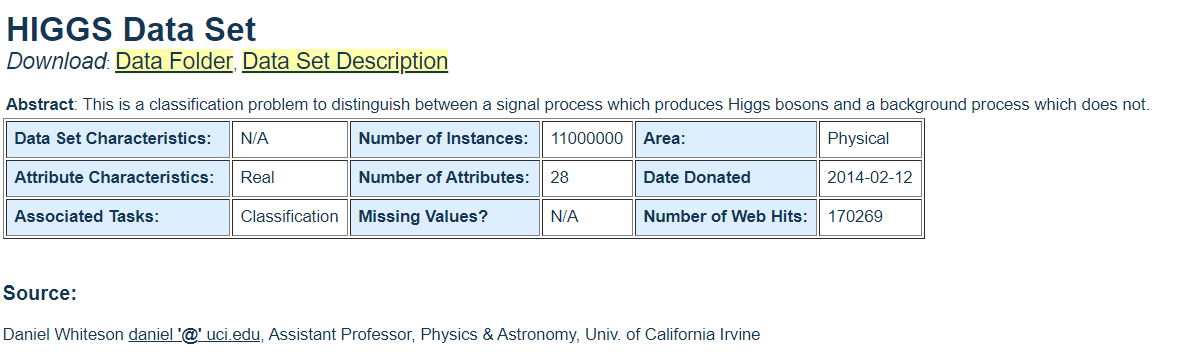

In [ ]:
## Downloading the Dataset
url = "http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)


In [ ]:
!ls -lrth HIGGS.csv.gz
# You might see that it is a big file of 2.7GB


In [ ]:
# Lets unzip the file and read it as a DataFrame with pandas
with gzip.open(filename) as f:

    features_train = pd.read_csv(f)

print(features_train.head())

In [ ]:
# We can add proporly the columns names
features_train.columns = ['label','pT', 'lepton_eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi',
                          'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi',
                          'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta',
                          'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb' ]

# Attribute Information:

The first column is the class label (1 for signal, 0 for background), followed
by the 28 features (21 low-level features then 7 high-level features): lepton
pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet
1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2
b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4
phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb. For more
detailed information about each feature see the original paper.

http://mlphysics.ics.uci.edu/data/higgs/readme.txt



In [ ]:
# Lets create a the subsets for training and test
df_train, df_test = train_test_split(features_train, test_size=0.2, random_state=42)
print(len(df_train))
print(len(df_test))

In [ ]:
# For academic purpose, lets create a sub-sample of each group, otherwise it will take longer time to be compute 
# ToDO:  Choose proper values, n>10k for training and n>1000 for test, to have a nice representation of the samples

df_train2 = df_train.sample(n=...,replace=False).reset_index()
df_test2 = df_test.sample(n=...,replace=False).reset_index()

#print(len(df_train2))
#print(df_train2.info())

In [ ]:
df_train2.head()

In [ ]:
df_test2.head()

In [ ]:
# Just a little of data analysis about the dataset. Regarding the label values, the data seems balance.
df_train2.hist(column='label')

In [ ]:
# Also checking if the labels in test are balanced.
df_test2.hist(column='label')

# Create the Dataset class, were you must return a sample dictionary of features and the corresponding label.

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    # ToDO
    return len(...)

  def __getitem__(self, idx):

    X = np.array(self.df.iloc[..., 2:])
    y = np.array(self.df.iloc[..., 1])

    # TODO:  Make work the Dataset Class

    sample={'features': ....float(),
            'label':...long()}


    return sample


In [ ]:
# Let's test the Data Set class if it work properly
prueba= Dataset(df=df_train2)


In [ ]:
# Let's print some samples from the dataset and check the dimensions.
for i, data in enumerate(prueba):
  print(i)
  print(data['features'].shape)
  print(data['label'].shape)
  break

# Pytorch-lightning: DataModule class

With Pytorch-lightning it is easier to manage the dataset and dataloaders

In [ ]:
class HIGSS_DataModule(pl.LightningDataModule):
  # Check that inherits from pytorch-lightning datamodules.
  # It is almost the same of pytorch-dataset, just that it can be defined the 
  # dataloader inside the class

    def __init__(self, df_train, df_val, Dataset,  batch_size = 128):
        super().__init__()
        self.df_train = df_train
        self.df_val  = df_val
        self.batch_size = batch_size
        self.Dataset = Dataset

    def setup(self, stage=None):
      # create the dataset objects for the train and validation

      self.dataset_train = self.Dataset(self.df_train)
      self.dataset_val  = self.Dataset(self.df_val)
      for i, data in enumerate(self.dataset_val):
        print(i)
        print(data['features'].shape)
        print(data['label'])
        break



    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=False )

In [ ]:
# Create the datamodule object

dm = HIGSS_DataModule(df_train=df_train2,
                               df_val=df_test2,
                               Dataset=Dataset,
                               batch_size = 128)

In [ ]:
# creating the dataset object for train and validation
dm.setup()

In [ ]:
# Testing the validation dataloader
for data in dm.val_dataloader():
  print(data['features'].shape)
  print(data['label'].shape)
  break

# Pytorch-lightning: LightningModule class

Inside the class, it is integrated with the datamodules, the model configurations, the training and validation steps (at each iteration), 
the optimizers and lr-schedulers among other methods available to be used.



In [ ]:
val_epoch_loss, val_epoch_acc = [], []
train_epoch_loss, train_epoch_acc = [], []

class MLP(pl.LightningModule):

    def __init__(self):
      super().__init__( )
      self.mlp = my_model
      
      
    def forward(self, x):
      return self.mlp(x)

    def predict(self, x):
      with torch.no_grad():
        y_hat = self(x)
        return torch.argmax(y_hat, axis=1)

    def compute_loss_and_acc(self, batch):
      x, y = batch['features'], batch['label']
      y_hat = self(x)
      loss = F.cross_entropy(y_hat, y)
      acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
      return loss, acc

    def training_step(self, batch, batch_idx):
      loss, acc = self.compute_loss_and_acc(batch)
      self.log('train_loss', loss)
      self.log('train_acc', acc, prog_bar=True)
      #print(f'Training_step: loss> {loss} acc:{acc}')
      return {'loss':loss,'acc':torch.tensor(acc)}
    
    def training_epoch_end(self, outputs):
      avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
      avg_train_acc  = torch.stack([x['acc'] for x in outputs]).mean()

      train_epoch_loss.append(avg_train_loss.item())
      train_epoch_acc.append(avg_train_acc.item())

      #print(f'Epoch {self.current_epoch} TrainLOSS:{avg_train_loss} TrainACC:{avg_train_acc}  ')


    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return {'val_loss': torch.tensor(loss.item()), 'val_acc': torch.tensor(acc)}

    def validation_epoch_end(self, outputs):
      avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
      avg_val_acc  = torch.stack([x['val_acc'] for x in outputs]).mean()
      self.log('EarlyStop_Log', avg_val_loss.detach(), on_epoch=True, sync_dist=True)
      
      val_epoch_loss.append(avg_val_loss.item())
      val_epoch_acc.append(avg_val_acc.item())

      #print(f'VAL-Epoch {self.current_epoch} LOSS:{avg_val_loss} ACC:{avg_val_acc} ')

    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        lr_scheduler = {'scheduler': MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.5,),'interval': 'epoch','frequency':1}

        return [optimizer], [lr_scheduler]

In [ ]:
# Create a Test Model as a sequential of linear layers, 
# ToDO: Set the proper value for the input_feature and output_feature

model_test =  torch.nn.Sequential(
          ....
      )
# create the object, check the pytorch-lighting module and how we connect to the model inside the class
my_model = model_test
# Creating the object, connects the model_test we just created.
mlp = MLP()

# ToDO: Check if it works properly, providing a random input tensor 
outuput = mlp(...)
print(outuput.shape)

# the output should be a tensor with shape: BZx2


# Pytorch-lightning: Callbacks.

Several methods are available for integrating into the model class, as Early-stopping, to save checkpoints, to monitor the GPUS_status, to profile the model, among others.

Check the documentation for more details: https://pytorch-lightning.readthedocs.io/en/latest/extensions/callbacks.html

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor='avg_val_acc',verbose=True,\
        save_last=True,\
        save_top_k=1,\
        period=1, \
        mode='max',)
early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
        min_delta=0.00, patience=5, verbose=False, mode='min')
    

# Pytorch-lightning: The Trainer

In the trainer method, is where the features are defined regarded the training details, such as the number of epochs for training, the callbacks to be used, the devices, number of nodes, among others.


In [ ]:
trainer = pl.Trainer(gpus=gpu,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stop_callback],
    max_epochs=50,
    )

# Then you call the fit method passing the PL-module and PL-Datamodule, to start training.
trainer.fit(mlp, dm)




In [ ]:
# Plot some results 
plt.plot(train_epoch_loss, label='Train-Loss')
plt.plot(val_epoch_loss, label='Val-Loss')
plt.legend()


In [ ]:
plt.plot(train_epoch_acc, label='Train-ACC')
plt.plot(val_epoch_acc, label='Val-ACC')
plt.legend()

# Overfitting

The best way to explore overfitting is to start with a simple model and then increase the model capacity. Increasing the number of parameters we increase the model capacity of learning some feature representations that are just related to the training data and not well suited for generalization.

Keep in mind that a deep learning model pursuits always generalization, and how it behaves in relation to new data. 

Unfortunately, there is not a defined way to procede in relation how to define the network architecture and number of parameters for certain application, as well as the amount of data necessary for training to get the best model, yet. 

The best method available is to train several times, starting with a simple model and monitoring the learning curves (the loss and metrics). Then increase the model capacity to overcome underfitting and stops when overfitting may arrive.

We will be using the MLP() class with the same training strategies for all the models, and training with early-stopping for 50 epochs.


In [ ]:
### Reset the logs and callbacks for the model ###
val_epoch_loss, val_epoch_acc = [], []
train_epoch_loss, train_epoch_acc = [], []
checkpoint_callback = ModelCheckpoint(monitor='avg_val_acc',verbose=True,\
        save_last=True,\
        save_top_k=1,\
        period=1, \
        mode='max',)
early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
        min_delta=0.00, patience=5, verbose=False, mode='min')
    

### Create a new model ####
# ToDO, Define a simple model with two linear layers and a ReLU as a activation.
tiny_model =  torch.nn.Sequential(
          ...
          )
my_model = tiny_model
mlp = MLP()
##### Creating the TRAINER ####
trainer = pl.Trainer(gpus=gpu,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stop_callback],
    max_epochs=50,
    )
trainer.fit(mlp, dm)

##  Plotting ###
plt.plot(train_epoch_loss, label='Train-Loss')
plt.plot(val_epoch_loss, label='Val-Loss')
plt.legend()

## Saving the logs the specific model ###
tiny_val_epoch_loss, tiny_val_epoch_acc      = val_epoch_loss, val_epoch_acc 
tiny_train_epoch_loss, tiny_train_epoch_acc  = train_epoch_loss, train_epoch_acc


# Small model

In [ ]:
### Reset the logs for the model ###
val_epoch_loss, val_epoch_acc = [], []
train_epoch_loss, train_epoch_acc = [], []
early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
        min_delta=0.00, patience=5, verbose=False, mode='min')
    

### Creating the new model ####
# ToDO: Increase the model capacity, defining a 3 layers MLP with ReLU activation.
small_model =  torch.nn.Sequential(
          ...
          )
my_model = small_model
mlp = MLP()
##### Creating the TRAINER ####
trainer = pl.Trainer(gpus=gpu,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stop_callback],
    max_epochs=50,
    )
trainer.fit(mlp, dm)

##  Plotting ###
plt.plot(train_epoch_loss, label='Train-Loss')
plt.plot(val_epoch_loss, label='Val-Loss')
plt.legend()

## Saving the logs the specific model ###
small_val_epoch_loss, small_val_epoch_acc      = val_epoch_loss, val_epoch_acc 
small_train_epoch_loss, small_train_epoch_acc  = train_epoch_loss, train_epoch_acc


# Bigger Net

In [ ]:
### Reset the logs for the model ###
val_epoch_loss, val_epoch_acc = [], []
train_epoch_loss, train_epoch_acc = [], []
early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
        min_delta=0.00, patience=5, verbose=False, mode='min')
    

### Creating the new model ####
# ToDO: Increase the model capacity, defining a 5 layers MLP with ReLU activation.

bigger_model =  torch.nn.Sequential(
          ...
          )

my_model = bigger_model
mlp = MLP()
#mlp.my_model = bigger_model
##### Creating the TRAINER ####
trainer = pl.Trainer(gpus=gpu,
    #checkpoint_callback=checkpoint_callback,
    callbacks=[early_stop_callback],
    max_epochs=50,
    )
trainer.fit(mlp, dm)

##  Plotting ###
plt.plot(train_epoch_loss, label='Train-Loss')
plt.plot(val_epoch_loss, label='Val-Loss')
plt.legend()

## Saving the logs the specific model ###
bigger_val_epoch_loss, bigger_val_epoch_acc      = val_epoch_loss, val_epoch_acc 
bigger_train_epoch_loss, bigger_train_epoch_acc  = train_epoch_loss, train_epoch_acc


# Bigger Dropout

In [ ]:
### Reset the logs for the model ###
val_epoch_loss, val_epoch_acc = [], []
train_epoch_loss, train_epoch_acc = [], []
early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
        min_delta=0.00, patience=5, verbose=False, mode='min')
    

### Creating the new model ####
bigger_dropout_model =  torch.nn.Sequential(
          torch.nn.Linear(28, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=0.5),

          torch.nn.Linear(100, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=0.5),

          torch.nn.Linear(100, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=0.5),

          torch.nn.Linear(100, 10),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(10, 2)
      )
my_model = bigger_dropout_model
mlp = MLP()

##### Creating the TRAINER ####
trainer = pl.Trainer(gpus=gpu,
    #checkpoint_callback=checkpoint_callback,
    callbacks=[early_stop_callback],
    max_epochs=50,
    )
trainer.fit(mlp, dm)

##  Plotting ###
plt.plot(train_epoch_loss, label='Train-Loss')
plt.plot(val_epoch_loss, label='Val-Loss')
plt.legend()

## Saving the logs the specific model ###
bigger_dropout_val_epoch_loss, bigger_dropout_val_epoch_acc      = val_epoch_loss, val_epoch_acc 
bigger_dropout_train_epoch_loss, bigger_dropout_train_epoch_acc  = train_epoch_loss, train_epoch_acc


# Lets plot the losses

As you may see, the best behaviour regarding overfitting is with the tiny model. 

A bigger model presents the best training loss curve, but overfits quite soon.


In [ ]:
##  Plotting ###
plt.plot(tiny_train_epoch_loss, label='Train-Loss-Tiny', color='green', marker='.', linestyle='solid')
plt.plot(tiny_val_epoch_loss, label='Val-Loss-Tiny', color='green', marker='o', linestyle='dashed')

plt.plot(small_train_epoch_loss, label='Train-Loss-Small', color='red', marker='.', linestyle='solid')
plt.plot(small_val_epoch_loss, label='Val-Loss-Small', color='red', marker='o', linestyle='dashed')

plt.plot(bigger_train_epoch_loss, label='Train-Loss-Bigger', color='blue', marker='.', linestyle='solid')
plt.plot(bigger_val_epoch_loss, label='Val-Loss-Bigger', color='blue', marker='o', linestyle='dashed')



plt.legend(loc='upper right' )


In [ ]:
# ToDO: Plot the same curves for the accuracy metric.

# Dropout

Dropout is one effective technique that is often used to fight overfitting.

The intuition behind is to deactive some neurons on each layers randomly. 

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

Let's see how it works with Pytorch.

In [ ]:
### Reset the logs for the model ###
val_epoch_loss, val_epoch_acc = [], []
train_epoch_loss, train_epoch_acc = [], []
early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
        min_delta=0.00, patience=5, verbose=False, mode='min')
    

### Creating the new model ####
bigger_dropout_model =  torch.nn.Sequential(
          torch.nn.Linear(28, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=0.5),

          torch.nn.Linear(100, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=0.5),

          torch.nn.Linear(100, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=0.5),

          torch.nn.Linear(100, 10),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(10, 2)
      )
my_model = bigger_dropout_model
mlp = MLP()

##### Creating the TRAINER ####
trainer = pl.Trainer(gpus=gpu,
    #checkpoint_callback=checkpoint_callback,
    callbacks=[early_stop_callback],
    max_epochs=50,
    )
trainer.fit(mlp, dm)

##  Plotting ###
plt.plot(train_epoch_loss, label='Train-Loss')
plt.plot(val_epoch_loss, label='Val-Loss')
plt.legend()

## Saving the logs the specific model ###
bigger_dropout_val_epoch_loss, bigger_dropout_val_epoch_acc      = val_epoch_loss, val_epoch_acc 
bigger_dropout_train_epoch_loss, bigger_dropout_train_epoch_acc  = train_epoch_loss, train_epoch_acc



# Regularizations

Another common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization" or in some cases 'weight-decay'.


In Pytorch, weight decay is implemented in almost any optimizer, by simple adding the factor value that will scale the weight norm for each parameter.



```
# optimizer = optim.Adam(bignet.parameters(), weight_decay=0.001, lr=0.001)

```




In [ ]:
val_epoch_loss, val_epoch_acc = [], []
train_epoch_loss, train_epoch_acc = [], []

class MLP_L2(pl.LightningModule):

    def __init__(self):
      super().__init__( )
      self.mlp = my_model
      
      
    def forward(self, x):
      return self.mlp(x)

    def predict(self, x):
      with torch.no_grad():
        y_hat = self(x)
        return torch.argmax(y_hat, axis=1)

    def compute_loss_and_acc(self, batch):
      x, y = batch['features'], batch['label']
      y_hat = self(x)
      loss = F.cross_entropy(y_hat, y)
      acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
      return loss, acc

    def training_step(self, batch, batch_idx):
      loss, acc = self.compute_loss_and_acc(batch)
      self.log('train_loss', loss)
      self.log('train_acc', acc, prog_bar=True)
      #print(f'Training_step: loss> {loss} acc:{acc}')
      return {'loss':loss,'acc':torch.tensor(acc)}
    
    def training_epoch_end(self, outputs):
      avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
      avg_train_acc  = torch.stack([x['acc'] for x in outputs]).mean()
      train_epoch_loss.append(avg_train_loss.item())
      train_epoch_acc.append(avg_train_acc.item())

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return {'val_loss': torch.tensor(loss.item()), 'val_acc': torch.tensor(acc)}

    def validation_epoch_end(self, outputs):
      avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
      avg_val_acc  = torch.stack([x['val_acc'] for x in outputs]).mean()
      self.log('EarlyStop_Log', avg_val_loss.detach(), on_epoch=True, sync_dist=True)
      val_epoch_loss.append(avg_val_loss.item())
      val_epoch_acc.append(avg_val_acc.item())

    def configure_optimizers(self):
      # Here we define the weight-decay parameter.
      # Todo Define a proper value for the weight-decay 

      optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay= ... )
      lr_scheduler = {'scheduler': MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.5,),'interval': 'epoch','frequency':1}

        return [optimizer], [lr_scheduler]

# Bigger L2 regularizer

Lets see how it works with the bigger model

In [ ]:
### Reset the logs for the model ###
val_epoch_loss, val_epoch_acc = [], []
train_epoch_loss, train_epoch_acc = [], []
early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
        min_delta=0.00, patience=5, verbose=False, mode='min')
    

### Creating the new model ####
bigger_regul2_model =  torch.nn.Sequential(
          torch.nn.Linear(28, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, 10),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(10, 2)
      )
my_model = bigger_regul2_model

# we now use the MLP class with l2-regularization.
# ToDo: create the class object
mlp = ...

##### Creating the TRAINER ####
trainer = pl.Trainer(gpus=gpu,
    #checkpoint_callback=checkpoint_callback,
    callbacks=[early_stop_callback],
    max_epochs=50,
    )
trainer.fit(mlp, dm)

##  Plotting ###
plt.plot(train_epoch_loss, label='Train-Loss')
plt.plot(val_epoch_loss, label='Val-Loss')
plt.legend()

## Saving the logs the specific model ###
bigger_regul2_val_epoch_loss, bigger_regul2_val_epoch_acc      = val_epoch_loss, val_epoch_acc 
bigger_regul2_train_epoch_loss, bigger_regul2_train_epoch_acc  = train_epoch_loss, train_epoch_acc


# Bigger Dropout and L2 regularizer

Combining both strategies for regularization

In [ ]:
### Reset the logs for the model ###
val_epoch_loss, val_epoch_acc = [], []
train_epoch_loss, train_epoch_acc = [], []
early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
        min_delta=0.00, patience=5, verbose=False, mode='min')
    

### Creating the new model ####
bigger_dropout_regul2_model =  torch.nn.Sequential(
          torch.nn.Linear(28, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=0.5),

          torch.nn.Linear(100, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=0.5),

          torch.nn.Linear(100, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Dropout(p=0.5),

          torch.nn.Linear(100, 10),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(10, 2)
      )
my_model = bigger_dropout_regul2_model
mlp = MLP_L2()

##### Creating the TRAINER ####
trainer = pl.Trainer(gpus=gpu,
    #checkpoint_callback=checkpoint_callback,
    callbacks=[early_stop_callback],
    max_epochs=50,
    )
trainer.fit(mlp, dm)

##  Plotting ###
plt.plot(train_epoch_loss, label='Train-Loss')
plt.plot(val_epoch_loss, label='Val-Loss')
plt.legend()

## Saving the logs the specific model ###
bigger_dropout_regul2_val_epoch_loss, bigger_dropout_regul2_val_epoch_acc      = val_epoch_loss, val_epoch_acc 
bigger_dropout_regul2_train_epoch_loss, bigger_dropout_regul2_train_epoch_acc  = train_epoch_loss, train_epoch_acc


In [ ]:
##  Plotting ###
#plt.plot(tiny_train_epoch_loss, label='Train-Loss-Tiny', color='green', marker='.', linestyle='solid')
#plt.plot(tiny_val_epoch_loss, label='Val-Loss-Tiny', color='green', marker='o', linestyle='dashed')

#plt.plot(small_train_epoch_loss, label='Train-Loss-Small', color='red', marker='.', linestyle='solid')
#plt.plot(small_val_epoch_loss, label='Val-Loss-Small', color='red', marker='o', linestyle='dashed')

plt.plot(bigger_train_epoch_loss, label='Train-Loss-Bigger', color='blue', marker='.', linestyle='solid')
plt.plot(bigger_val_epoch_loss, label='Val-Loss-Bigger', color='blue', marker='o', linestyle='dashed')

plt.plot(bigger_dropout_train_epoch_loss, label='Train-Loss-Dropout', color='magenta', marker='.', linestyle='solid')
plt.plot(bigger_dropout_val_epoch_loss, label='Val-Loss-Dropout', color='magenta', marker='o', linestyle='dashed')

plt.plot(bigger_dropout_regul2_train_epoch_loss, label='Train-Loss-L2reg', color='black', marker='.', linestyle='solid')
plt.plot(bigger_dropout_regul2_val_epoch_loss, label='Val-Loss-L2reg', color='black', marker='o', linestyle='dashed')


plt.legend(bbox_to_anchor=(1.5, 0.9))


In [ ]:
##  Plotting ###
plt.plot(tiny_train_epoch_loss, label='Train-Loss-Tiny', color='green', marker='.', linestyle='solid')
plt.plot(tiny_val_epoch_loss, label='Val-Loss-Tiny', color='green', marker='o', linestyle='dashed')

plt.plot(small_train_epoch_loss, label='Train-Loss-Small', color='red', marker='.', linestyle='solid')
plt.plot(small_val_epoch_loss, label='Val-Loss-Small', color='red', marker='o', linestyle='dashed')

#plt.plot(bigger_train_epoch_loss, label='Train-Loss-Bigger', color='blue', marker='.', linestyle='solid')
#plt.plot(bigger_val_epoch_loss, label='Val-Loss-Bigger', color='blue', marker='o', linestyle='dashed')

plt.plot(bigger_dropout_val_epoch_loss, label='Train-Loss-Dropout', color='magenta', marker='.', linestyle='solid')
plt.plot(bigger_dropout_val_epoch_loss, label='Val-Loss-Dropout', color='magenta', marker='o', linestyle='dashed')

plt.plot(bigger_dropout_regul2_train_epoch_loss, label='Train-Loss-L2reg', color='black', marker='.', linestyle='solid')
plt.plot(bigger_dropout_regul2_val_epoch_loss, label='Val-Loss-L2reg', color='black', marker='o', linestyle='dashed')


plt.legend(bbox_to_anchor=(1.5, 0.9))


In [ ]:
##  Plotting ###
#plt.plot(tiny_train_epoch_acc, label='Train-ACC-Tiny', color='green', marker='.', linestyle='solid')
plt.plot(tiny_val_epoch_acc, label='Val-ACC-Tiny', color='green', marker='o', linestyle='dashed')

#plt.plot(small_train_epoch_acc, label='Train-ACC-Small', color='red', marker='.', linestyle='solid')
plt.plot(small_val_epoch_acc, label='Val-ACC-Small', color='red', marker='o', linestyle='dashed')

#plt.plot(bigger_train_epoch_acc, label='Train-ACC-Bigger', color='blue', marker='.', linestyle='solid')
plt.plot(bigger_val_epoch_acc, label='Val-ACC-Bigger', color='blue', marker='o', linestyle='dashed')

#plt.plot(bigger_dropout_val_epoch_acc, label='Train-ACC-Dropout', color='magenta', marker='.', linestyle='solid')
plt.plot(bigger_dropout_val_epoch_acc, label='Val-ACC-Dropout', color='magenta', marker='o', linestyle='dashed')

#plt.plot(bigger_dropout_regul2_train_epoch_acc, label='Train-ACC-L2reg', color='black', marker='.', linestyle='solid')
plt.plot(bigger_dropout_regul2_val_epoch_acc, label='Val-ACC-L2reg', color='black', marker='o', linestyle='dashed')


#plt.legend(loc='upper right' )
plt.legend(bbox_to_anchor=(1.5, 0.9))



# Lets see how it works with the tiny model

In [ ]:
### Reset the logs for the model ###
val_epoch_loss, val_epoch_acc = [], []
train_epoch_loss, train_epoch_acc = [], []
early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
        min_delta=0.00, patience=5, verbose=False, mode='min')
    

### Creating the new model ####
# TODO: Same configuration as tiny model but with dropout
tiny_dropout_regul2_model =  torch.nn.Sequential(
          ...
      )


my_model = tiny_dropout_regul2_model
mlp = MLP_L2()

##### Creating the TRAINER ####
trainer = pl.Trainer(gpus=gpu,
    #checkpoint_callback=checkpoint_callback,
    callbacks=[early_stop_callback],
    max_epochs=50,
    )
trainer.fit(mlp, dm)

##  Plotting ###
plt.plot(train_epoch_loss, label='Train-Loss')
plt.plot(val_epoch_loss, label='Val-Loss')
plt.legend()

## Saving the logs the specific model ###
tiny_dropout_regul2_val_epoch_loss, tiny_dropout_regul2_val_epoch_acc      = val_epoch_loss, val_epoch_acc 
tiny_dropout_regul2_train_epoch_loss, tiny_dropout_regul2_train_epoch_acc  = train_epoch_loss, train_epoch_acc


In [ ]:
##  Plotting ###
plt.plot(tiny_train_epoch_loss, label='Train-Loss-Tiny', color='green', marker='.', linestyle='solid')
plt.plot(tiny_val_epoch_loss, label='Val-Loss-Tiny', color='green', marker='o', linestyle='dashed')

#plt.plot(small_train_epoch_loss, label='Train-Loss-Small', color='red', marker='.', linestyle='solid')
#plt.plot(small_val_epoch_loss, label='Val-Loss-Small', color='red', marker='o', linestyle='dashed')

#plt.plot(bigger_train_epoch_loss, label='Train-Loss-Bigger', color='blue', marker='.', linestyle='solid')
#plt.plot(bigger_val_epoch_loss, label='Val-Loss-Bigger', color='blue', marker='o', linestyle='dashed')

#plt.plot(bigger_dropout_val_epoch_loss, label='Train-Loss-Dropout', color='magenta', marker='.', linestyle='solid')
#plt.plot(bigger_dropout_val_epoch_loss, label='Val-Loss-Dropout', color='magenta', marker='o', linestyle='dashed')

#plt.plot(bigger_dropout_regul2_val_epoch_loss, label='Train-Loss-L2reg', color='yellow', marker='.', linestyle='solid')
#plt.plot(bigger_dropout_regul2_val_epoch_loss, label='Val-Loss-L2reg', color='yellow', marker='o', linestyle='dashed')

plt.plot(tiny_dropout_regul2_train_epoch_loss, label='Train-Loss-L2reg-Dropout-Tiny', color='cyan', marker='.', linestyle='solid')
plt.plot(tiny_dropout_regul2_val_epoch_loss, label='Val-Loss-L2reg-Dropout-Tiny', color='cyan', marker='o', linestyle='dashed')

plt.legend(loc='best' )


In [ ]:
##  Plotting ###
plt.plot(tiny_train_epoch_acc, label='Train-ACC-Tiny', color='green', marker='.', linestyle='solid')
plt.plot(tiny_val_epoch_acc, label='Val-ACC-Tiny', color='green', marker='o', linestyle='dashed')

#plt.plot(small_train_epoch_loss, label='Train-Loss-Small', color='red', marker='.', linestyle='solid')
#plt.plot(small_val_epoch_loss, label='Val-Loss-Small', color='red', marker='o', linestyle='dashed')

#plt.plot(bigger_train_epoch_loss, label='Train-Loss-Bigger', color='blue', marker='.', linestyle='solid')
#plt.plot(bigger_val_epoch_loss, label='Val-Loss-Bigger', color='blue', marker='o', linestyle='dashed')

#plt.plot(bigger_dropout_val_epoch_loss, label='Train-Loss-Dropout', color='magenta', marker='.', linestyle='solid')
#plt.plot(bigger_dropout_val_epoch_loss, label='Val-Loss-Dropout', color='magenta', marker='o', linestyle='dashed')

#plt.plot(bigger_dropout_regul2_val_epoch_loss, label='Train-Loss-L2reg', color='yellow', marker='.', linestyle='solid')
#plt.plot(bigger_dropout_regul2_val_epoch_loss, label='Val-Loss-L2reg', color='yellow', marker='o', linestyle='dashed')

plt.plot(tiny_dropout_regul2_train_epoch_acc, label='Train-ACC-L2reg-Dropout-Tiny', color='cyan', marker='.', linestyle='solid')
plt.plot(tiny_dropout_regul2_val_epoch_acc, label='Val-ACC-L2reg-Dropout-Tiny', color='cyan', marker='o', linestyle='dashed')

plt.legend(loc='best' )


# Conclusions

The most common ways to prevent overfitting in neural networks are:

* Get more data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout (depends on the model).

In feature lectures you will see other important strategies like:

* data-augmentation
* batch normalization (well suited for conv-nets)


# References:
- https://juansensio.com/blog/061_self_attention
- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb

